# Conditional Convolutional Variational Autoencoders for MNIST

이름: 최정우

학번: M2018076

Colab link: http://bit.ly/2Uot1pj

---

MNIST 데이터셋을 이용해 conditional variational autoencoder (Conditional VAE) 기반 generative model을 구축한다. 


단, 과제는 다음 조건을 만족해야 한다.

- 조건(condition)은 데이터의 label로 부여한다.

- 데이터의 representation z에 대한 확률분포 p(z)가 다차원 normal distribution을 따른다고 가정한다.

- 딥네트워크는 컨볼루션(convolution) 연산을 통해 설계한다.  

---

- 조건을 Conditional VAE의 인코더와 디코더에 어떻게 텐서 형태를 취해 입력으로 줘야하는지 명시하고, 이에 대해 논의한다.

- 학습을 마친 Conditional VAE에 대해, MNIST 데이터셋의 representation p(z)가 *조건별로* 모두 다차원 normal distribution을 따르는지 확인한다.

- 조건별로 representation p(z)의 분포를 가시화 한다.

- z의 차원을 바꿔가며 실험해 본다.

- 학습을 마친 Conditional VAE의 decoder만으로 generative model을 구성한다. 이 때, p(z)에서 샘플링한 z 값을 decoder으로 주었을 때 손글씨 숫자 이미지가 만들어지는지 확인한다. 의미있게 만들어진 이미지는 어떤 특징을 가지고 있는지 논의한다.

- (* 이것 이외에도 의미있는 실험들을 스스로 생각하고 수행해 본다)

## 목차


1. Dependencies & Prerequisites
2. MNIST 데이터셋 불러오기
3. 네트워크 구성
4. 네트워크 훈련 및 weight 불러오기 
5. 학습 결과 분석



## 1. Dependencies & Prerequisites

###Install Prerequisites

Tensorflow probability를 사용하기위해서는 nightly 버전의 tensorflow를 설치해야한다.

Weight를 저장 및 불러오기에 사용하기위해 PyDrive 를 설치한다.

In [1]:
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q tfp-nightly
!pip3 install h5py pyyaml 
!pip install -U -q PyDrive

    100% |████████████████████████████████| 345.3MB 83kB/s 
    100% |████████████████████████████████| 3.0MB 8.5MB/s 
    100% |████████████████████████████████| 430kB 12.8MB/s 
    100% |████████████████████████████████| 61kB 23.6MB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
    100% |████████████████████████████████| 921kB 15.1MB/s 
    100% |████████████████████████████████| 993kB 18.9MB/s 


###Import

사용할 라이브러리를 import 하고, 자주사용되는 라이브러리는 약칭으로 지정한다.

In [2]:
import glob, os       #저장 경로관련 모듈 임포트

import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_probability as tfp


from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np

tfd = tfp.distributions

print("Tensorflow: ", tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print("Keras: ", tf.keras.__version__)  # 케라스 버전을 확인한다.

print("Tensorflow Probability: ", tfp.__version__)       # TFP 버젼을 확인한다.


W0417 13:03:31.252030 140466607933312 deprecation_wrapper.py:76] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/math/root_search.py:51: The name reduce_all is deprecated. Please use reduce_all instead.

W0417 13:03:31.254561 140466607933312 deprecation_wrapper.py:76] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/bijectors/masked_autoregressive.py:412: The name nn.relu is deprecated. Please use nn.relu instead.

W0417 13:03:31.259583 140466607933312 deprecation_wrapper.py:76] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/bijectors/masked_autoregressive.py:529: The name keras.layers.Layer is deprecated. Please use keras.layers.Layer instead.

W0417 13:03:31.349505 140466607933312 deprecation_wrapper.py:76] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/edward2/random_variable.py:191: The name Tensor is deprecated. Please use Tensor instead.

W0417 13:03:31.351217 140466607933312 

Tensorflow:  2.0.0-dev20190417
Keras:  2.2.4-tf
Tensorflow Probability:  0.7.0-dev20190417


###구글 드라이브 연결
Colab의 현재 세션과 구글 드라이브를 연결하기 위해서 사용한다.

Weight를 저장하거나 저장된 weight를 불러오는데 필요하다.

사용방법: 코드 실행시 오른쪽 GDrive_Auth 아래에 생성되는 링크를 타고 구글 로그인을 한뒤에 권한을 수락하고 보이는 코드를 복사하여 링크 아래의 사각형에 붙여넣은 후 엔터를 친다.

In [0]:
#@title GDrive_Auth { vertical-output: true, display-mode: "both" }

# Colab의 현재 세션과 구글 드라이브를 연결하기 위해서 사용한다.
# weight를 저장하거나 불러오는데 필요하다.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 2. MNIST 데이터셋 불러오기

Keras 라이브러리를 이용하여 MNIST 데이터셋을 불러오고, 데이터 값이 0과 1사이를 가지도록 정규화후 이진화 한다.

Training dataset 과 Validation dataset 만으로 학습시킨다.

Validation dataset 은 훈련시 옵션을 통해 Training dataset 의 20%를 사용한다.

학습된 네트워크를 실험할 때는 Test dataset 을 이용하여 실험을 진행한다.


In [4]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalizing the images to the range of [0., 1.]
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images[train_images >= 0.5] = 1.0
train_images[train_images <  0.5] = 0.0
test_images[test_images >= 0.5] = 1.0
test_images[test_images <  0.5] = 0.0

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape)
print(test_images.shape)
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels[0].dtype)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(28, 28, 1)
float32
uint8


### Onehot encoding
훈련시 사용할 condition을 Onehot encoding 하여 사용한다.

In [5]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

# 데이터 변환 확인
print(train_label_onehots.shape)
print(test_label_onehots.shape)

(60000, 10)
(10000, 10)


####Tensor로 변환(Numpy 이용)

이미지의 사이즈가 2 by 2라고 할때, 주어진 Tensor를  repeat, reshape, transpose 의 방식을 거쳐서 이미지의 픽셀당 조건을 주는 방식으로 변경시킬 수 있다. 

In [0]:
k = np.array([[1,2,3],[4,5,6],[7,8,9]])
y = np.repeat(k, 2*2).reshape((-1,3,2,2)).transpose(0,2,3,1)
print(y.shape)
print(y)

(3, 2, 2, 3)
[[[[1 2 3]
   [1 2 3]]

  [[1 2 3]
   [1 2 3]]]


 [[[4 5 6]
   [4 5 6]]

  [[4 5 6]
   [4 5 6]]]


 [[[7 8 9]
   [7 8 9]]

  [[7 8 9]
   [7 8 9]]]]


실제 onehot encoding 된 라벨값에 적용시켰을때 원하는 조건에 결과가 1이 됨을 알수있다.

In [46]:
train_label_onehots_img = np.repeat(train_label_onehots, 28*28). reshape((-1,num_classes,28,28)).transpose(0,2,3,1)
test_label_onehots_img = np.repeat(test_label_onehots, 28*28). reshape((-1,num_classes,28,28)).transpose(0,2,3,1)


# 데이터 변환 확인
print(train_label_onehots.shape)
print(test_label_onehots.shape)
print(train_label_onehots_img.shape)

print(train_label_onehots[0])
print(train_labels[0])

print(test_label_onehots[0])
print(test_labels[0])

(60000, 10)
(10000, 10)
(60000, 28, 28, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


####Tensor로 변환(Tensorflow 이용)
네트워크의 간략화를 위해서 Numpy 를 이용한 변환을 Tensorflow 의 함수를 이용하여 같은 효과를 내도록 만든다.

이전의 출력결과와 같음을 확인할수 있다.

In [0]:
tf.tile([3,1],[4])

# 한 줄 연산
# tf.transpose(tf.reshape(tf.squeeze(tf.reshape(tf.tile(tf.reshape(k, (-1, 1)), (1, 4)), (1, -1))),(-1,3,2,2)), perm=[0, 2, 3, 1])

a = tf.reshape(k, (-1, 1))
a = tf.tile(a , (1, 4))
a = tf.reshape(a, (1, -1))
a = tf.squeeze(a)
a = tf.reshape(a,(-1,3,2,2))
a = tf.transpose(a, perm=[0, 2, 3, 1])
print(a)

tf.Tensor(
[[[[1 2 3]
   [1 2 3]]

  [[1 2 3]
   [1 2 3]]]


 [[[4 5 6]
   [4 5 6]]

  [[4 5 6]
   [4 5 6]]]


 [[[7 8 9]
   [7 8 9]]

  [[7 8 9]
   [7 8 9]]]], shape=(3, 2, 2, 3), dtype=int64)


## 3. 네트워크 구성


###Base network model (실행 x)

네트워크의 그림을 출력하기위해서 기본 네트워크의 모습을 선언한다. 현재 잠재변수(z)는 4로 지정이 되어있고 이것을 변경시키며 훈련시킬 예정이다. 이를 위해 객체화를 진행하는데, 객체화 후에는 네트워크의 전체적인 그림이 제대로 출력되지 않아서 Base network에 대한 네트워크 구조도를 통해 변화하는 부분을 예상할 수 있다.

In [0]:
enc_dim = 4
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [0]:
# encoder (inference model)

## input layers
x = layers.Input(shape=(28,28,1))
c_onehot_img = layers.Input(shape=(28,28,10))
c_onehot = layers.Input(shape=(10))

## encoding layers
encoder_layer1 = layers.Conv2D(32, 5, padding='same', activation='relu')
encoder_layer2 = layers.Conv2D(32, 5, strides=2, padding='same', activation='relu')
encoder_layer3 = layers.Conv2D(64, 3, padding='same', activation='relu')
encoder_layer4 = layers.Conv2D(64, 3, padding='same', activation='relu')
encoder_layer5 = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')
encoder_layer6 = layers.Conv2D(128, 3, padding='same', activation='relu')
encoder_layer7 = layers.Conv2D(4 * enc_dim, 7, strides=1, padding='valid', activation='relu')
encoder_layer8 = layers.Dense(enc_dim + enc_dim)
encoder_output_layer = tfp.layers.IndependentNormal(enc_dim, 
                                                    activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1))

## encoder network

inputs = layers.concatenate([x, c_onehot_img])
x_encoded = encoder_layer1(inputs)
x_encoded = encoder_layer2(x_encoded)
x_encoded = encoder_layer3(x_encoded)
x_encoded = encoder_layer4(x_encoded)
x_encoded = encoder_layer5(x_encoded)
x_encoded = encoder_layer6(x_encoded)
x_encoded = encoder_layer7(x_encoded)
x_encoded = layers.Flatten()(x_encoded)
x_encoded = encoder_layer8(x_encoded)
z = encoder_output_layer(x_encoded)

In [0]:
# decoder (generative model)

## decoding layers
decoder_layer1 = layers.Conv2DTranspose(128, 7, padding='valid', activation='relu')
decoder_layer2 = layers.Conv2DTranspose(128, 3, padding='same', activation='relu')
decoder_layer3 = layers.Conv2DTranspose(128, 3, padding='same', activation='relu')

decoder_layer4 = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')

decoder_layer5 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')
decoder_layer6 = layers.Conv2DTranspose(32, 5, padding='same', activation='relu')
decoder_layer7 = layers.Conv2DTranspose(32, 5, strides=2, padding='same', activation='relu')

decoder_layer8 = layers.Conv2D(1, 5, padding='same', activation=None)

decoder_output_layer = tfp.layers.IndependentBernoulli(event_shape=(28,28, 1), 
                                                       convert_to_tensor_fn=tfd.Bernoulli.logits)

## decoder network
z_cond = layers.concatenate([z, c_onehot])
z_cond = layers.Reshape([1,1,12])(z_cond)

x_decoded = decoder_layer1(z_cond)
x_decoded = decoder_layer2(x_decoded)
x_decoded = decoder_layer3(x_decoded)
x_decoded = decoder_layer4(x_decoded)
x_decoded = decoder_layer5(x_decoded)
x_decoded = decoder_layer6(x_decoded)
x_decoded = decoder_layer7(x_decoded)
x_decoded = decoder_layer8(x_decoded)

x_decoded = layers.Flatten()(x_decoded)

y = decoder_output_layer(x_decoded)


#### Visualization

네트워크의 구조는 인코딩네트워크와 디코딩 네트워크로 구성되어있다.
각 네트워크에 입력이 들어갈때는 항상 onehot 인코딩된 조건이 함께 입력된다.
인코딩 네트워크에서는 onehot 인코딩된 조건이 이미지의 크기에 맞게 확장된 조건이 concatenate 되어 입력이된다.
반면, 디코딩네트워크에서는 확장되지 않은 onehot 인코딩이 P(z)와 함께 입력된다.

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 28, 28, 10)] 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 28, 28, 11)   0           input_22[0][0]                   
                                                                 input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 28, 28, 32)   8832        concatenate_6[0][0]        

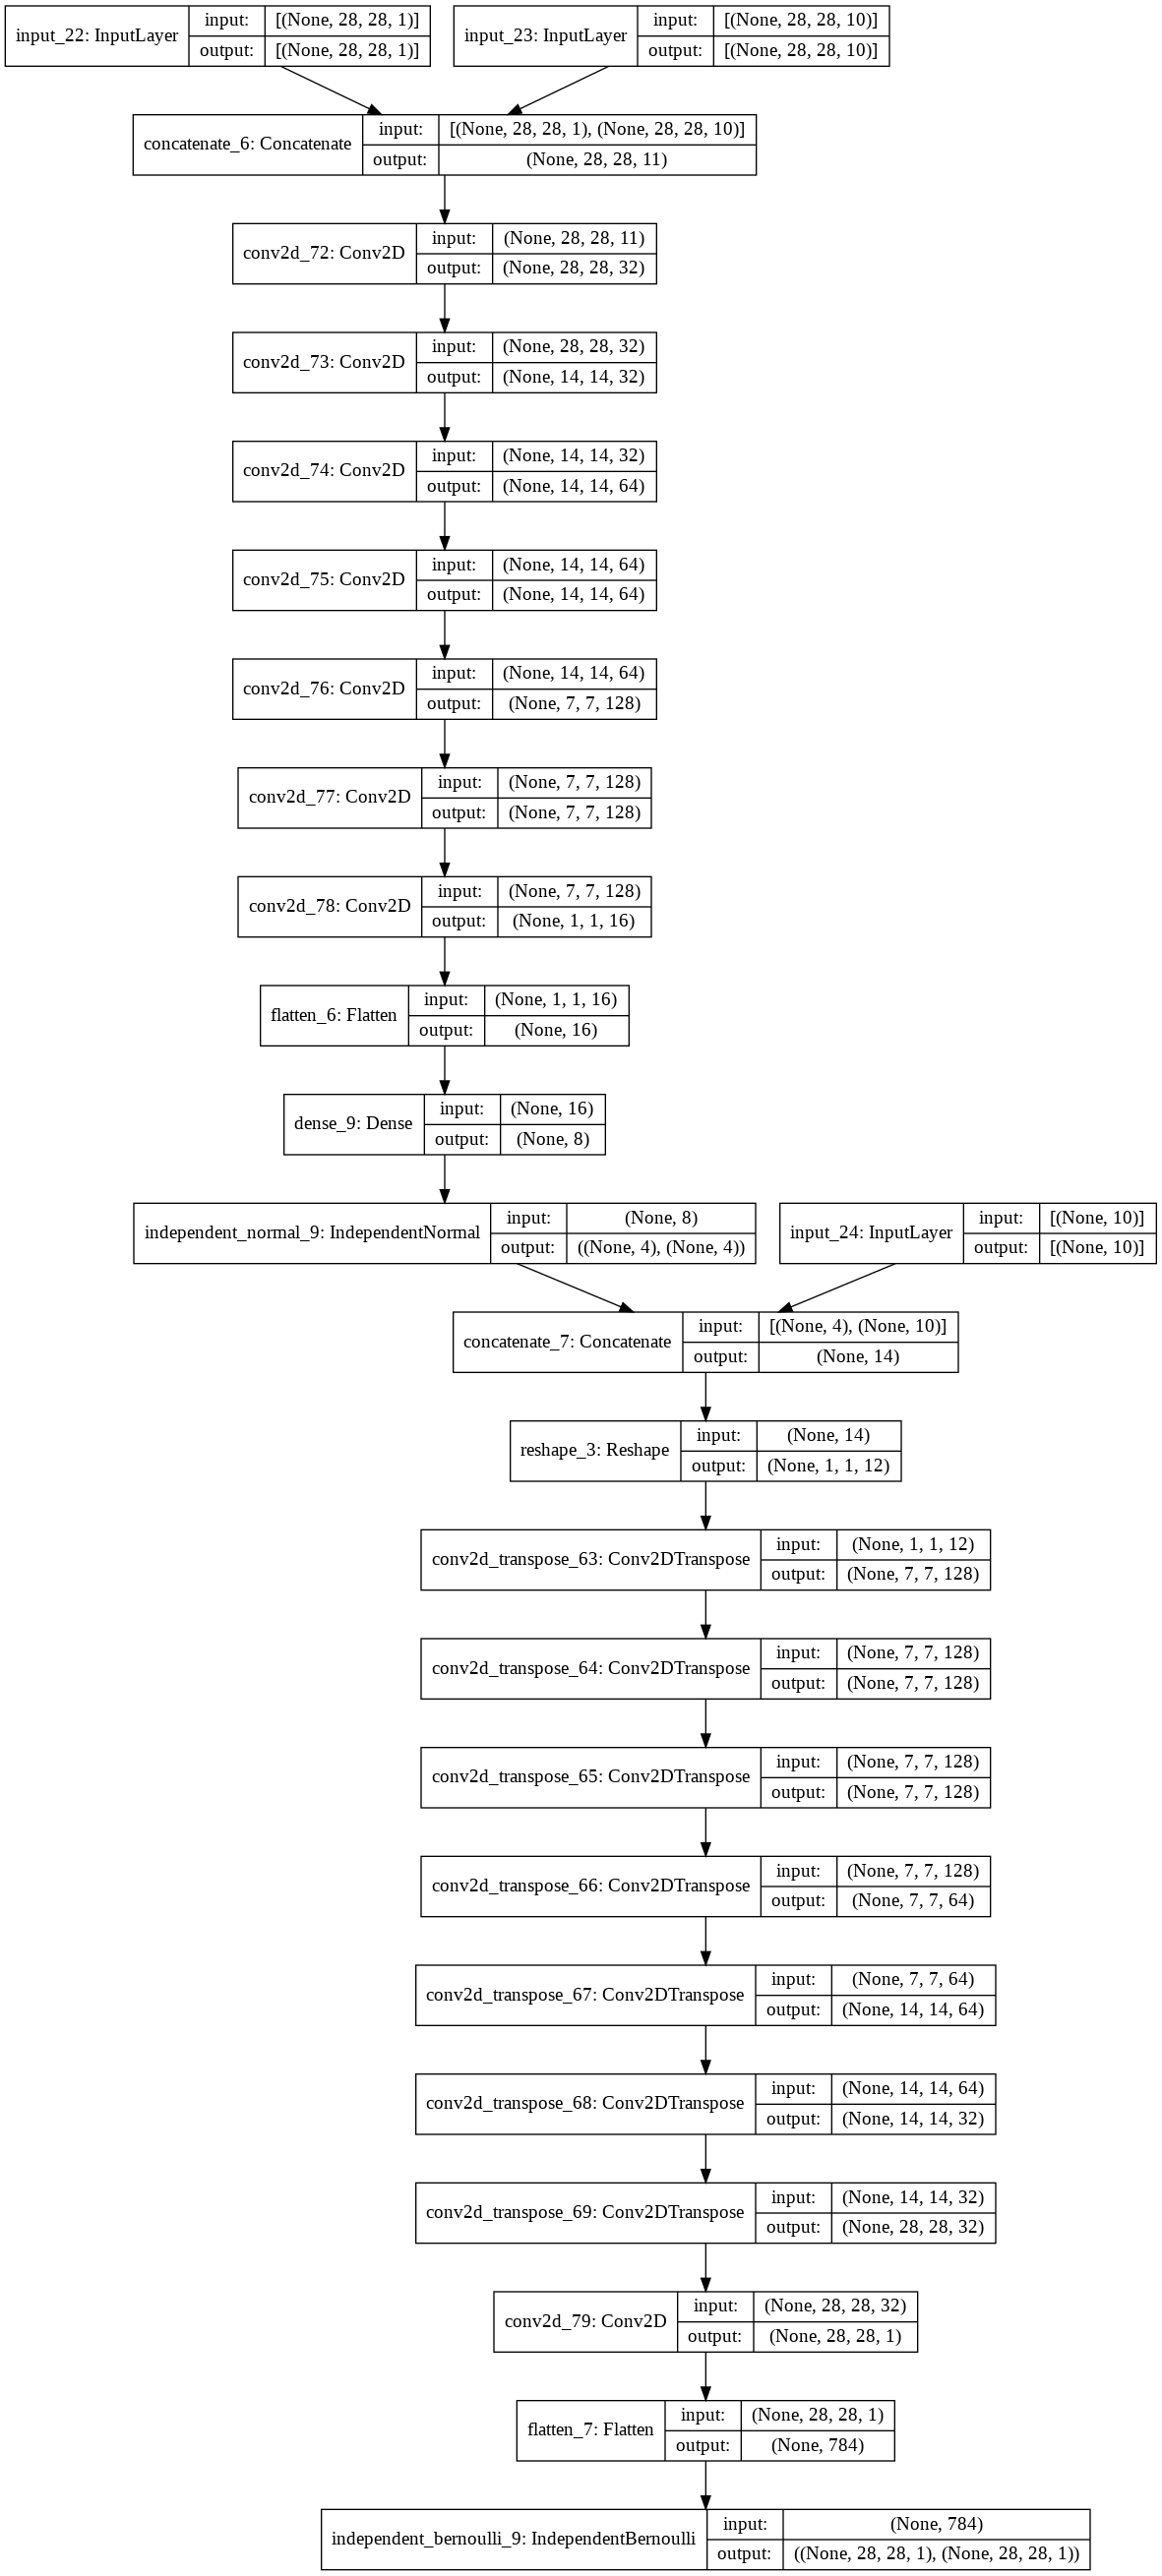

In [0]:
cvae = models.Model([x, c_onehot_img, c_onehot], y)
cvae.compile(optimizer='adam',
             loss=lambda y_true, y_pred: -y_pred.log_prob(y_true),
             metrics=['mae'])

cvae.summary()
tf.keras.utils.plot_model(cvae, 'basic_cvae_model.png', show_shapes=True)

###네트워크 객체화

네트워크를 변형시키며 훈련시킬때, 객체화를 하게되면 원하는 값을 편하게 변경시키며 훈련시킬수있다.
따라서 잠재변수 z의 크기를 변경시키기 위해 객체 선언에 enc_dim 을 입력받게하고, 이에 따라서 네트워크 레이어의 사이즈도 변경시킨다.

이전 네트워크에서는 인코더 네트워크와 디코더 네트워크의 입력되는 조건의 형식이 다르게 되는데, 이를 imgify라는 tf.Tensor 변형함수를 통해서 변형되지 않은 단순 onehot 인코딩된 조건이 입력 되더라도, 이미지의 사이즈에 맞는 onehot 인코딩 조건이 concatenate 되도록 하였다.

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, enc_dim):
        super(CVAE, self).__init__()
        
        self.enc_dim = enc_dim
        
        self.prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)
        
        ## input layers
        self.x = layers.Input(shape=(28,28,1))
        self.c_onehot = layers.Input(shape=(10))
        
        # imgify make c_onehot to c_onehot_img
        #self.c_onehot_img = layers.Input(shape=(28,28,10))
        

        ## encoding layers
        self.encoder_layer1 = layers.Conv2D(32, 5, padding='same', activation='relu')
        self.encoder_layer2 = layers.Conv2D(32, 5, strides=2, padding='same', activation='relu')
        self.encoder_layer3 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.encoder_layer4 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.encoder_layer5 = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')
        self.encoder_layer6 = layers.Conv2D(128, 3, padding='same', activation='relu')
        self.encoder_layer7 = layers.Conv2D(4 * self.enc_dim, 7, strides=1, padding='valid', activation='relu')
        self.encoder_layer8 = layers.Dense(self.enc_dim + self.enc_dim)
        self.encoder_output_layer = tfp.layers.IndependentNormal(self.enc_dim, 
                                                            activity_regularizer=tfp.layers.KLDivergenceRegularizer(self.prior, weight=1))
        ## decoding layers
        self.decoder_layer1 = layers.Conv2DTranspose(128, 7, padding='valid', activation='relu')
        self.decoder_layer2 = layers.Conv2DTranspose(128, 3, padding='same', activation='relu')
        self.decoder_layer3 = layers.Conv2DTranspose(128, 3, padding='same', activation='relu')
        self.decoder_layer4 = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')
        self.decoder_layer5 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')
        self.decoder_layer6 = layers.Conv2DTranspose(32, 5, padding='same', activation='relu')
        self.decoder_layer7 = layers.Conv2DTranspose(32, 5, strides=2, padding='same', activation='relu')
        self.decoder_layer8 = layers.Conv2D(1, 5, padding='same', activation=None)
        self.decoder_output_layer = tfp.layers.IndependentBernoulli(event_shape=(28,28, 1), 
                                                       convert_to_tensor_fn=tfd.Bernoulli.logits)

    def imgify(self, x):
        num_classes = 10
        
        #np.repeat(x, 28*28). reshape((-1,num_classes,28,28)).transpose(0,2,3,1)
        x = tf.reshape(x, (-1, 1))
        x = tf.tile(x , (1, 28*28))
        x = tf.reshape(x, (1, -1))
        x = tf.squeeze(x)
        x = tf.reshape(x,(-1,num_classes,28,28))
        x = tf.transpose(x, perm=[0, 2, 3, 1])
        return x
    
        ## encoder network
    def encoder(self, x, c_onehot):
        c_onehot_img = self.imgify(c_onehot)
        inputs = layers.concatenate([x, c_onehot_img])
        x_encoded = self.encoder_layer1(inputs)
        x_encoded = self.encoder_layer2(x_encoded)
        x_encoded = self.encoder_layer3(x_encoded)
        x_encoded = self.encoder_layer4(x_encoded)
        x_encoded = self.encoder_layer5(x_encoded)
        x_encoded = self.encoder_layer6(x_encoded)
        x_encoded = self.encoder_layer7(x_encoded)
        x_encoded = layers.Flatten()(x_encoded)
        x_encoded = self.encoder_layer8(x_encoded)
        z = self.encoder_output_layer(x_encoded)

        return z

    ## decoder network
    def decoder(self, z, c_onehot):

        z_cond = layers.concatenate([z, c_onehot])
        z_cond = layers.Reshape([1,1,(10+self.enc_dim)])(z_cond)

        x_decoded = self.decoder_layer1(z_cond)
        x_decoded = self.decoder_layer2(x_decoded)
        x_decoded = self.decoder_layer3(x_decoded)
        x_decoded = self.decoder_layer4(x_decoded)
        x_decoded = self.decoder_layer5(x_decoded)
        x_decoded = self.decoder_layer6(x_decoded)
        x_decoded = self.decoder_layer7(x_decoded)
        x_decoded = self.decoder_layer8(x_decoded)
        x_decoded = layers.Flatten()(x_decoded)
        y = self.decoder_output_layer(x_decoded)

        return y
    
    
    def call(self, inputs):
        x, c_onehot = inputs
        return self.decoder(self.encoder(x, c_onehot), c_onehot)

## 4. Network 훈련 및 weight 불러오기


### Training (실행 x)
잠재 변수 z의 크기에따라서 훈련에 필요한 시간도 커질것이라 예상하여
기본 20 epoch를 기준으로 2\*z 만큼 더 훈련시키게 하였다.
잠재 변수 z는 2부터 31까지 총 30번 변경시킨 네트워크를 만들어 훈련시킨다.

Validation loss를 기준으로 early stopping 을 실행하며 총 7번 validation loss가 이전보다 개선되지 않을시 훈련을 종료하게 된다.
또한 validation loss 를 계산할 데이터는 training dataset 에서 20%를 나누어 validation dataset으로 사용한다.

다 훈련된 네트워크는 인증받은 구글 드라이브에 저장하여, 훈련이 끊기더라도 계속해서 다음 네트워크를 훈련시킬수 있도록 하였다.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 20
batch_size = 40

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto') # 조기종료 콜백함수 정의

for encoded_size in range(2,32):
           
    network = CVAE(encoded_size)
    network.compile(optimizer='adam',
                        loss=lambda y_true, y_pred: -y_pred.log_prob(y_true),
                        metrics=['mae'])
    network.fit([train_images, train_label_onehots], train_images, 
                    epochs=epochs+(2*encoded_size), 
                    batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks = [early_stopping])
    network.summary()
    checkpoint_name = "CVAE_L"+str(encoded_size)
    network.save_weights(checkpoint_name)

    # Google auth refresh
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Upload weights
    for f in glob.glob(checkpoint_name+"*"):
        print("Upload file:",f)
        # Upload model
        model_file = drive.CreateFile({'title' : f})
        model_file.SetContentFile(f)
        model_file.Upload()

Train on 48000 samples, validate on 12000 samples
Epoch 1/52
48000/48000 [==============================] - 23s 471us/sample - loss: 155.1419 - mae: 7.8979 - val_loss: 129.5219 - val_mae: 9.2964
Epoch 2/52
48000/48000 [==============================] - 17s 356us/sample - loss: 123.7431 - mae: 9.8079 - val_loss: 118.8442 - val_mae: 10.3475
Epoch 3/52
48000/48000 [==============================] - 17s 357us/sample - loss: 115.8698 - mae: 9.9822 - val_loss: 112.8790 - val_mae: 10.5280
Epoch 4/52
48000/48000 [==============================] - 17s 358us/sample - loss: 110.6664 - mae: 10.0058 - val_loss: 108.1413 - val_mae: 9.1105
Epoch 5/52
48000/48000 [==============================] - 18s 369us/sample - loss: 105.9974 - mae: 10.1513 - val_loss: 105.7142 - val_mae: 10.1083
Epoch 6/52
48000/48000 [==============================] - 18s 366us/sample - loss: 103.2079 - mae: 10.1407 - val_loss: 103.5256 - val_mae: 10.2209
Epoch 7/52
48000/48000 [==============================] - 18s 370us/sampl

W0416 11:42:08.008540 140004656420736 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Model: "cvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  8832      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  25632     
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  36928     
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  73856     
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  147584    
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  401472 

W0416 11:52:48.352231 140004656420736 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: CVAE_L17.data-00000-of-00003
Upload file: CVAE_L17.index
Upload file: CVAE_L17.data-00002-of-00003
Upload file: CVAE_L17.data-00001-of-00003
Train on 48000 samples, validate on 12000 samples
Epoch 1/56
48000/48000 [==============================] - 19s 400us/sample - loss: 162.6793 - mae: 7.1264 - val_loss: 132.2598 - val_mae: 9.7002
Epoch 2/56
48000/48000 [==============================] - 18s 379us/sample - loss: 125.2677 - mae: 9.7940 - val_loss: 116.9216 - val_mae: 11.0263
Epoch 3/56
48000/48000 [==============================] - 18s 380us/sample - loss: 112.6028 - mae: 10.6756 - val_loss: 109.8380 - val_mae: 10.5176
Epoch 4/56
48000/48000 [==============================] - 18s 374us/sample - loss: 107.2900 - mae: 10.6483 - val_loss: 106.5263 - val_mae: 9.8468
Epoch 5/56
48000/48000 [==============================] - 18s 375us/sample - loss: 104.9399 - mae: 10.4633 - val_loss: 105.3407 - val_mae: 10.2837
Epoch 6/56
48000/48000 [==============================] - 18s 375

W0416 12:01:04.982008 140004656420736 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: CVAE_L18.data-00002-of-00003
Upload file: CVAE_L18.data-00000-of-00003
Upload file: CVAE_L18.data-00001-of-00003
Upload file: CVAE_L18.index
Train on 48000 samples, validate on 12000 samples
Epoch 1/58
48000/48000 [==============================] - 19s 397us/sample - loss: 161.2357 - mae: 7.4630 - val_loss: 129.7943 - val_mae: 9.6078
Epoch 2/58
48000/48000 [==============================] - 18s 383us/sample - loss: 124.8474 - mae: 9.6798 - val_loss: 122.5202 - val_mae: 9.0721
Epoch 3/58
48000/48000 [==============================] - 18s 378us/sample - loss: 115.5710 - mae: 10.1967 - val_loss: 111.5295 - val_mae: 9.8516
Epoch 4/58
48000/48000 [==============================] - 18s 375us/sample - loss: 108.7259 - mae: 10.5078 - val_loss: 106.9425 - val_mae: 10.9160
Epoch 5/58
48000/48000 [==============================] - 18s 374us/sample - loss: 104.6725 - mae: 10.5278 - val_loss: 104.5720 - val_mae: 9.8340
Epoch 6/58
48000/48000 [==============================] - 18s 378us

W0416 12:12:59.818676 140004656420736 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Model: "cvae_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           multiple                  8832      
_________________________________________________________________
conv2d_25 (Conv2D)           multiple                  25632     
_________________________________________________________________
conv2d_26 (Conv2D)           multiple                  18496     
_________________________________________________________________
conv2d_27 (Conv2D)           multiple                  36928     
_________________________________________________________________
conv2d_28 (Conv2D)           multiple                  73856     
_________________________________________________________________
conv2d_29 (Conv2D)           multiple                  147584    
_________________________________________________________________
conv2d_30 (Conv2D)           multiple                  47674

W0416 12:25:07.382221 140004656420736 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Model: "cvae_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           multiple                  8832      
_________________________________________________________________
conv2d_33 (Conv2D)           multiple                  25632     
_________________________________________________________________
conv2d_34 (Conv2D)           multiple                  18496     
_________________________________________________________________
conv2d_35 (Conv2D)           multiple                  36928     
_________________________________________________________________
conv2d_36 (Conv2D)           multiple                  73856     
_________________________________________________________________
conv2d_37 (Conv2D)           multiple                  147584    
_________________________________________________________________
conv2d_38 (Conv2D)           multiple                  50184

### Weight 다운로드

주어진 링크에 저장된 weight의 압축파일을 받아서 압축 해제한다.

In [7]:
# Download weights zip file
link = 'https://drive.google.com/open?id=1QS05L0-_3Me2m-m7sSj4BQ0_6Ht6kXK-'

# 웨이트 폴더 다운로드
file3 = drive.CreateFile({'id': link.split('=')[-1]})
print('Downloading file %s from Google Drive' % file3['title'])
file3.GetContentFile(file3['title'])  # Save Drive file as a local file

# 다운받은 웨이트 폴더 압축 해제
!unzip -o CVAE.zip

W0417 13:35:46.448972 140466607933312 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pydrive/files.py", line 134, in __getitem__
    return dict.__getitem__(self, key)
KeyError: 'title'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the abov

Archive:  CVAE.zip
  inflating: CVAE/CVAE_L27.data-00002-of-00003  
  inflating: CVAE/CVAE_L28.data-00002-of-00003  
  inflating: CVAE/CVAE_L30.data-00000-of-00003  
  inflating: CVAE/CVAE_L30.data-00002-of-00003  
  inflating: CVAE/CVAE_L31.data-00000-of-00003  
  inflating: CVAE/CVAE_L29.data-00000-of-00003  
  inflating: CVAE/CVAE_L31.data-00002-of-00003  
  inflating: CVAE/CVAE_L29.index     
  inflating: CVAE/CVAE_L28.index     
  inflating: CVAE/CVAE_L28.data-00000-of-00003  
  inflating: CVAE/CVAE_L30.index     
  inflating: CVAE/CVAE_L27.index     
  inflating: CVAE/CVAE_L29.data-00002-of-00003  
  inflating: CVAE/CVAE_L26.data-00002-of-00003  
  inflating: CVAE/CVAE_L26.index     
  inflating: CVAE/CVAE_L26.data-00000-of-00003  
  inflating: CVAE/CVAE_L27.data-00000-of-00003  
  inflating: CVAE/CVAE_L25.data-00002-of-00003  
  inflating: CVAE/CVAE_L31.index     
  inflating: CVAE/CVAE_L23.index     
  inflating: CVAE/CVAE_L25.index     
  inflating: CVAE/CVAE_L24.data-00000-of

## 5. 학습 결과 분석

### Test dataset processing
여러번 연산을 진행 할 것 이기 때문에, 모든 네트워크에 대한 테스트셋의 결과를 연산해둔다.

In [8]:
# 가시화할 데이터셋 생성
encoded_img_list = []
decoded_img_list = []

for encoded_size in range(2,32):
    network = CVAE(encoded_size)
    network.build([[1,28,28,1], [1,10]])

    checkpoint_name = 'CVAE/CVAE_L'+str(encoded_size)
    network.load_weights(checkpoint_name)

    encoded_img_list.append(network.encoder(test_images, test_label_onehots))
    decoded_img_list.append(network.decoder(network.encoder(test_images, test_label_onehots).sample(),test_label_onehots))


W0417 13:36:32.527354 140466607933312 deprecation_wrapper.py:76] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/layers/distribution_layer.py:969: The name math.softplus is deprecated. Please use math.softplus instead.

W0417 13:36:33.034321 140466607933312 deprecation_wrapper.py:76] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/layers/distribution_layer.py:1901: The name keras.utils.serialize_keras_object is deprecated. Please use keras.utils.serialize_keras_object instead.



### 네트워크가 조건에 대해 Normal distribution 을 구성하는지 확인

2부터 31까지 값을 변화 시킨 네트워크의 각각의 조건에 해당하는 잠재변수를 조건별로 나누어 가시화 하였다.
잠재변수의 크기가 커짐에 따라 Normal distribution 더 잘 만족하는 것을 볼 수 있다.

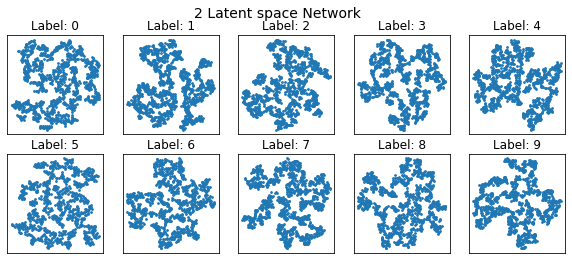

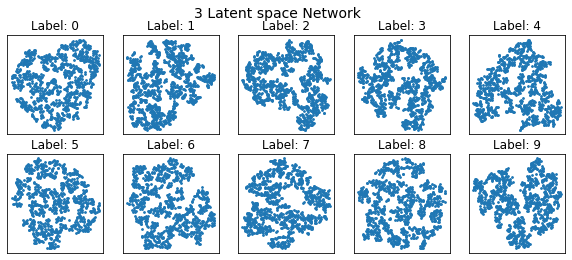

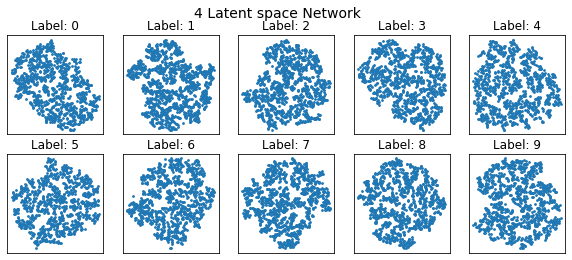

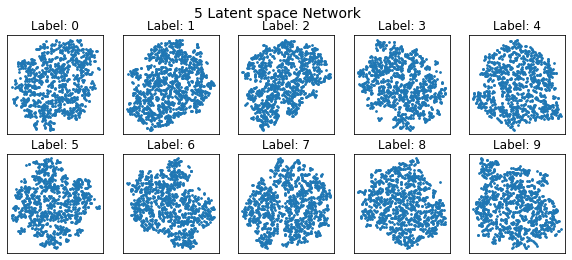

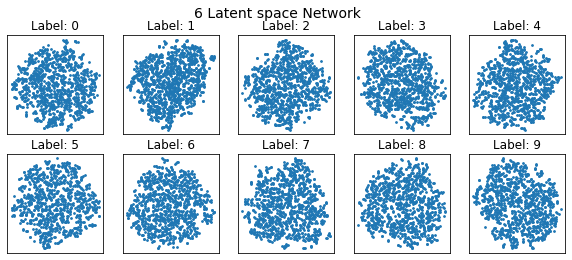

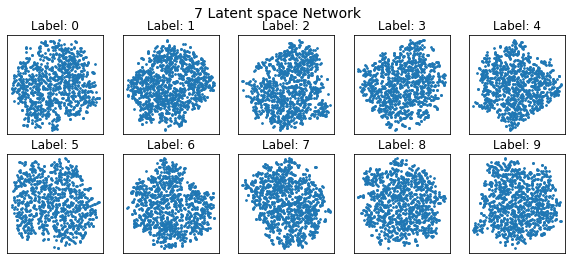

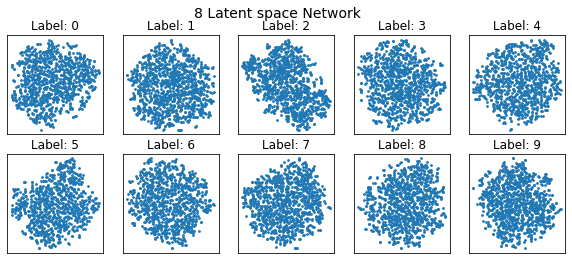

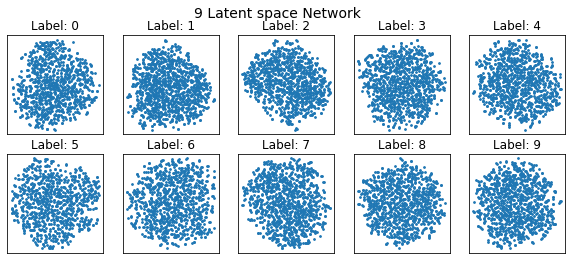

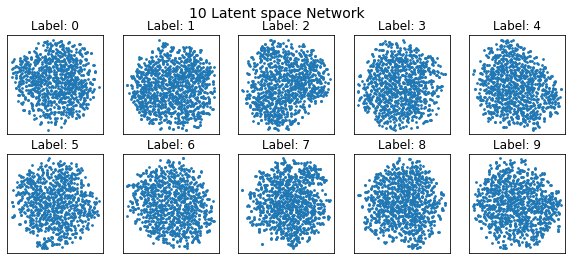

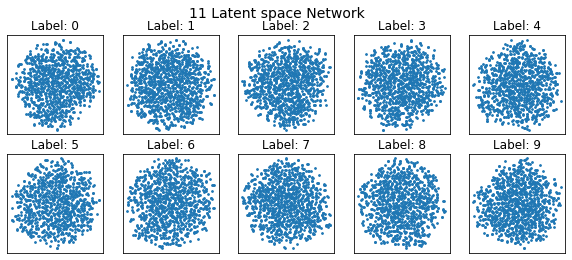

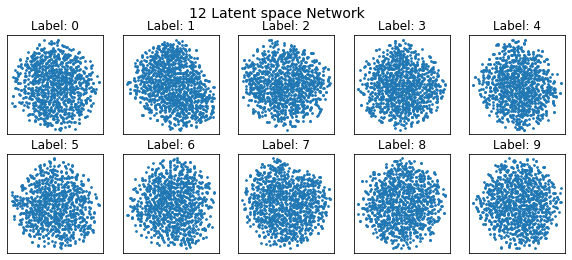

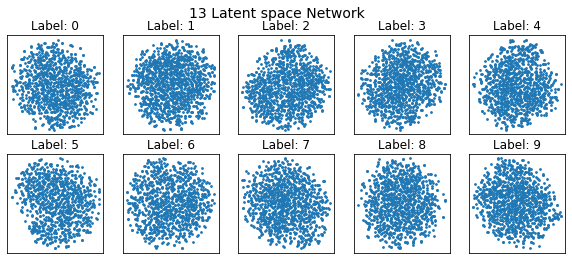

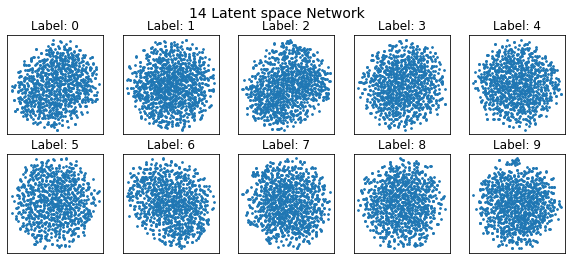

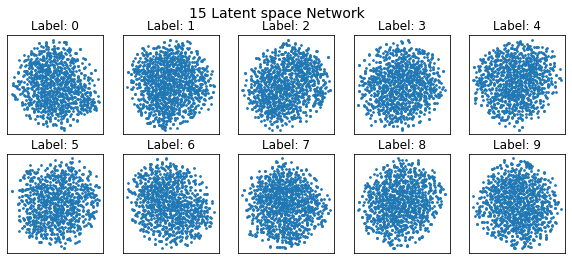

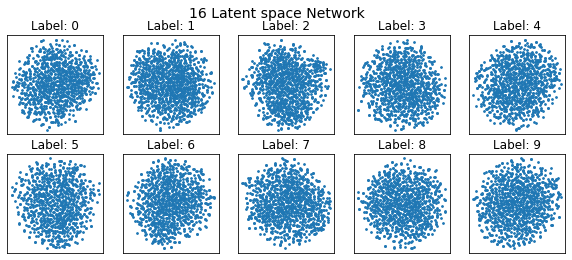

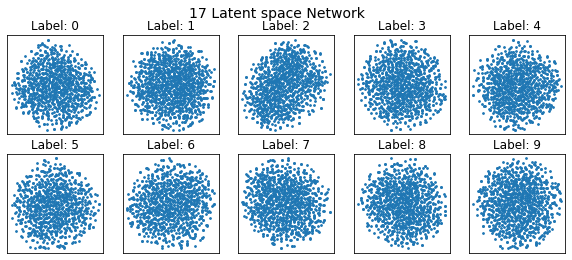

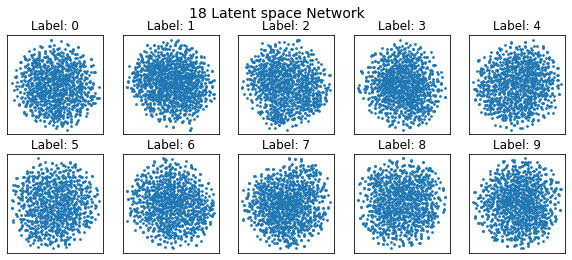

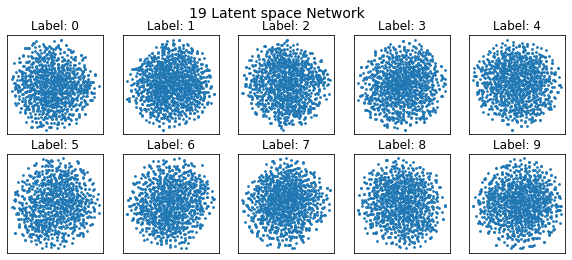

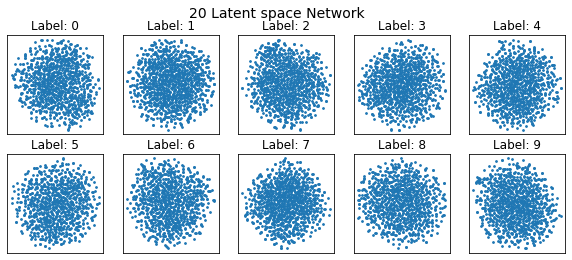

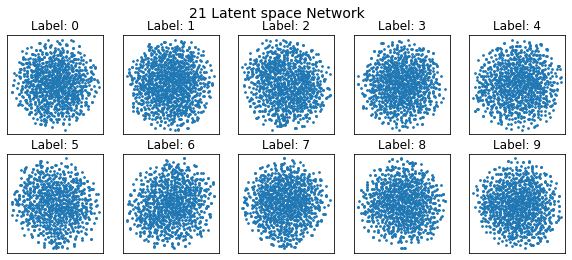

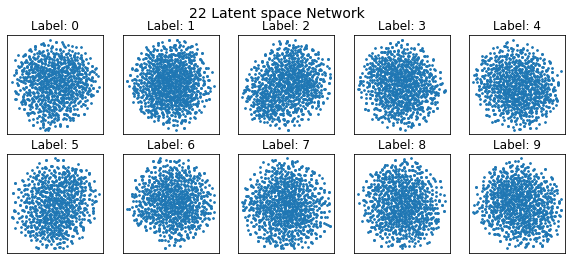

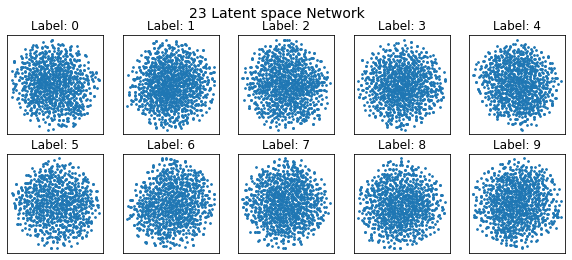

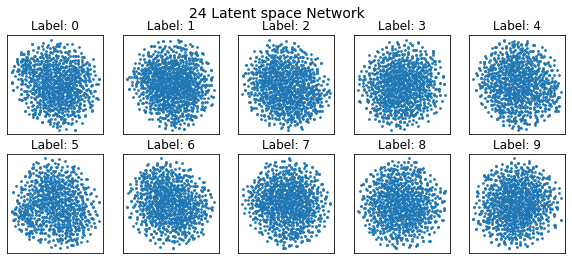

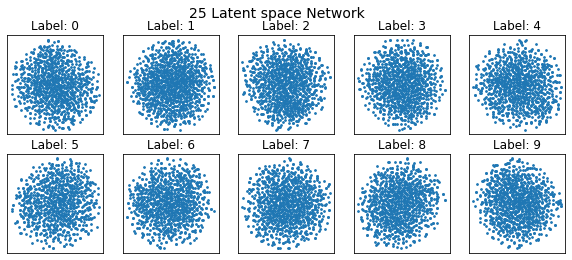

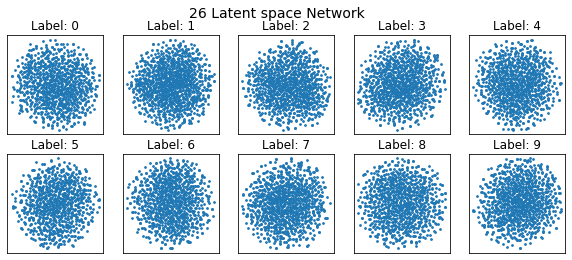

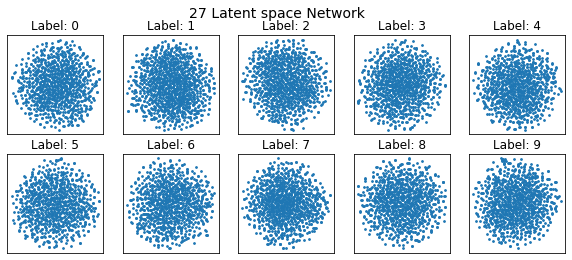

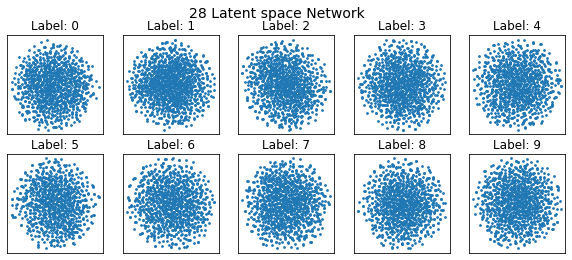

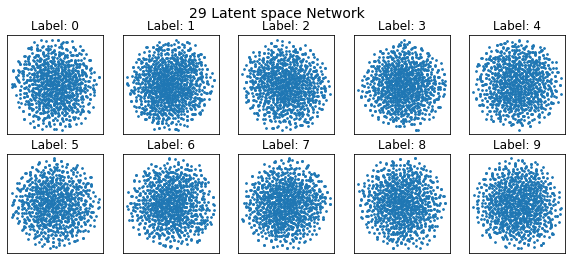

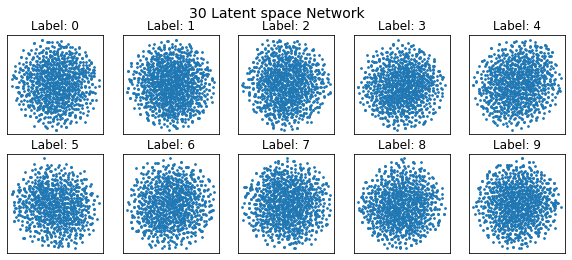

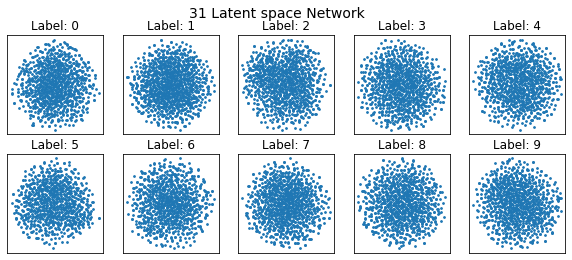

In [12]:
# 로딩된 MNIST 데이터 가시화
from sklearn.manifold import TSNE
import matplotlib as mplt
import matplotlib.pyplot as plt
mplt.rcParams.update({'figure.max_open_warning': 0})

for j in range(30):
    z = encoded_img_list[j].sample().numpy()
    plt.figure(figsize=(10, 4))
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        X = TSNE(n_components=2).fit_transform(z[test_labels==i])
        plt.scatter(X[:, 0], X[:, 1], s=3)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text("Label: "+str(i))
    plt.suptitle(str(j+2)+" Latent space Network", fontsize=14)
plt.show() 

### 잠재변수의 크기에 따른 잠재변수의 분포 비교

잠재변수의 크기가 8일때 가장 작으면서도 normal distribution 에 가까운 값을 띄는 것을 확인 할 수 있다.

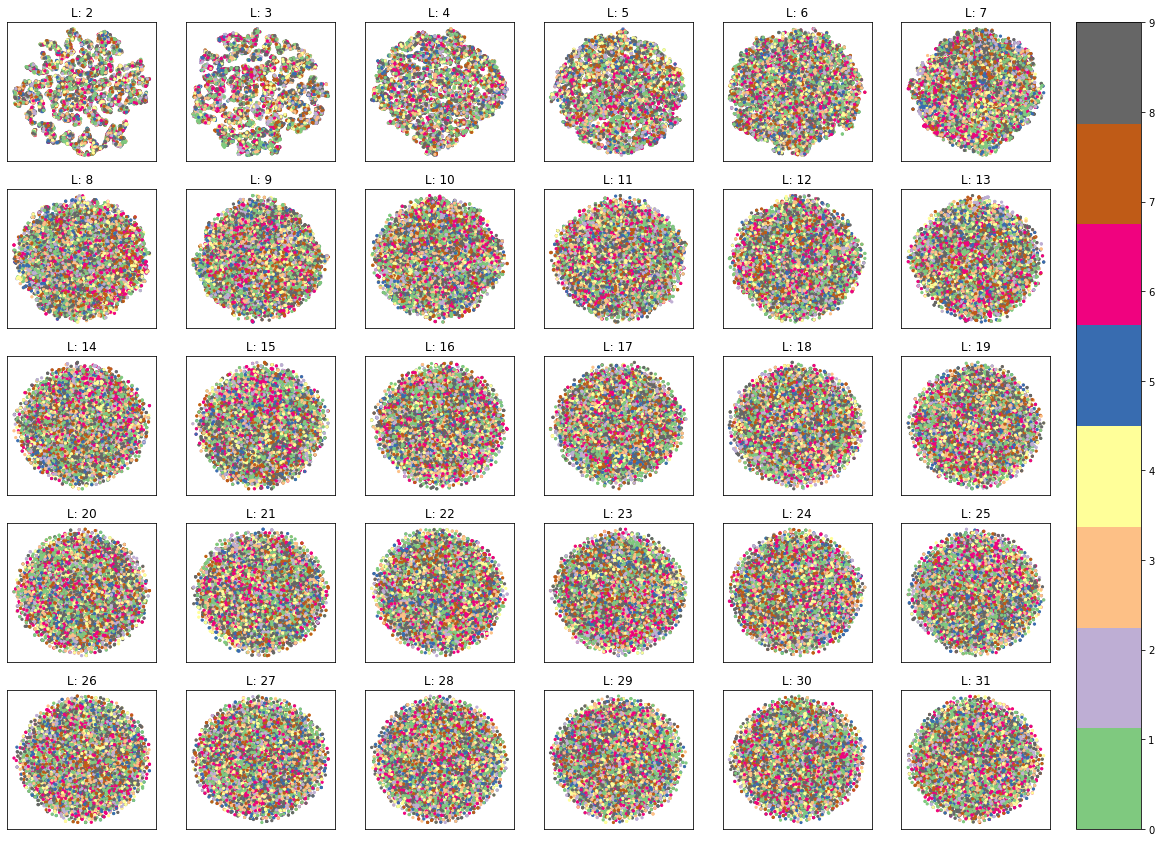

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 14))

Latent_list = list(range(2,32))

for i, en_list in enumerate(encoded_img_list):
    ax = plt.subplot(5, 6, i+1)
    X = TSNE(n_components=2).fit_transform(en_list.sample().numpy())
    plt.scatter(X[:, 0], X[:, 1], s=5, c=test_labels, cmap=plt.cm.Accent)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text("L: "+str(i%len(Latent_list)+2))
        
plt.subplots_adjust(bottom=0.1, right=0.93, top=0.9)
cax = plt.axes([0.95, 0.1, 0.05, 0.8])
plt.colorbar(cax=cax)
plt.show() 

### 잠재변수실험

가장 작은 잠재변수의 크기를 가지면서, normal distribution 에 비슷하게 뵈이는것은 잠재변수의 크기가 8일 때이다. 
따라서 8일때의 네트워크를 불러와 잠재변수 실험을 진행한다.

In [30]:
encoded_size = 8

network = CVAE(encoded_size)
network.build([[1,28,28,1], [1,10]])

checkpoint_name = 'CVAE/CVAE_L'+str(encoded_size)
network.load_weights(checkpoint_name)

Condition과 각각의 잠재변수값을 실제로 변경시키며, 이를 디코더네트워크에 inference 하게 되면 아래의 그림과 같은 결과를 얻을수 있다.

Condition 이 고정되면 그 조건의 숫자가 계속 표시된다.
그리고 잠재변수를 변경시키면 숫자의 모양이 변하게 된다.
본 네트워크에서 z3는 숫자의 두꺼움을 표시하고, z4는 숫자의 휘어짐의 방향을 나타내며, z6는 기울기를 나타내는 것을 실험적으로 확인 하였다.

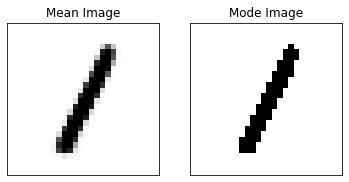

In [83]:
#@title Change z manually {run: 'auto'}

condition = 1 #@param {type:"slider", min:0, max:9, step:1}
z0 = 0.657  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z1 = 0.053  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z2 = -0.102  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z3 = -0.029  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z4 = 0  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z5 = -0.126  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z6 = -1.003  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z7 = 0.0  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }


z_tensor = tf.constant([[z0, z1, z2, z3, z4, z5, z6, z7]], tf.float32)
cond_np = np.zeros([1,10]).astype(np.float32)
cond_np[0][condition] = 1.0
cond_tensor = tf.convert_to_tensor(cond_np, dtype=np.float32)

decoded_img = network.decoder(z_tensor, cond_tensor)

assert isinstance(decoded_img, tfd.Distribution)

ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img.mean().numpy().reshape(28,28), cmap=plt.cm.Greys)
ax1.title.set_text("Mean Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(decoded_img.mode().numpy().reshape(28,28), cmap=plt.cm.Greys)
ax2.title.set_text("Mode Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
